In [1]:
# Hypothesis: smaller kernel sizes will lead to higher accuracies of classification in fined-tuned image classification
# We think this is likely due to the ability of the CNN to detect smaller features between relatively similar images of the same species
# Independent Variables: kernel size
# Constant Variables: number of layers, types of layers, input shape, epoches, hyperparamaters(depth,padding)
# Dependent Variables: Accuracy
# Limitations: we are foregoing pure accuracy for experimental reasons - we could get higher accuracy if we tried but we're keeping
# things constant for consistancy between models
# Currently only using Input, Convolutional, Relu, Pool, and FC/Dense layers. Can add Dense and Dropout if we have time
# Reference to www.cs231n.github.io/convolutional-networks

In [2]:
# 3. Import libraries and modules
import os, cv2, argparse
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import RandomState
np.random.seed(123)  # for reproducibility
import sys
import random

/home/cfu288/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# INPUT
TRAIN_DIR = './training/'
TEST_DIR = './validation/'
EPOCHS = 10
HEIGHT = 150
WIDTH = 150

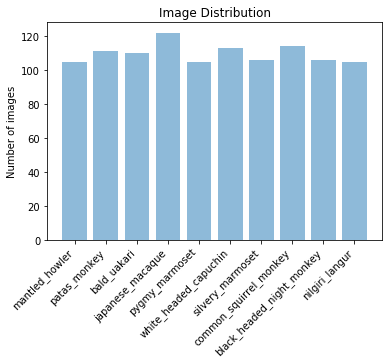

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,105,26
1,n1,erythrocebus_patas,patas_monkey,111,28
2,n2,cacajao_calvus,bald_uakari,110,27
3,n3,macaca_fuscata,japanese_macaque,122,30
4,n4,cebuella_pygmea,pygmy_marmoset,105,26
5,n5,cebus_capucinus,white_headed_capuchin,113,28
6,n6,mico_argentatus,silvery_marmoset,106,26
7,n7,saimiri_sciureus,common_squirrel_monkey,114,28
8,n8,aotus_nigriceps,black_headed_night_monkey,106,27
9,n9,trachypithecus_johnii,nilgiri_langur,105,26


In [4]:
# # Setup, Read in images, Preprocess images for training
TRAIN_IMG, TRAIN_CLS, TEST_IMG, TEST_CLS = ([] for i in range(4))
COLS = ['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images']
LABELS = pd.read_csv('./monkey_labels.txt', names=COLS, skiprows=1)
CLASSES = [x for x in range(0, len(LABELS))]

# print(len(TRAIN_IMG))
titles = LABELS.iloc[:,2].tolist()
for x in range(len(titles)):
    titles[x] = titles[x].strip()
y_pos = np.arange(len(titles))
vals = LABELS.iloc[:,3].tolist()

plt.bar(y_pos, vals, align='center', alpha=0.5)
plt.xticks(y_pos, titles, rotation=45, ha='right')
plt.ylabel("Number of images")
plt.title("Image Distribution")
plt.show()
LABELS

In [5]:
TRAIN_DATAGEN = ImageDataGenerator(rescale=1./255,
                                   rotation_range=25, 
                                   horizontal_flip=True, 
                                   zoom_range=0.1, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   fill_mode='nearest'
                                  )

TEST_DATAGEN = ImageDataGenerator(rescale=1./255)

TRAIN_GENERATOR = TRAIN_DATAGEN.flow_from_directory(
        TRAIN_DIR,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')
print(TRAIN_GENERATOR.image_shape)

TEST_GENERATOR = TEST_DATAGEN.flow_from_directory(
        TEST_DIR,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')

print(TEST_GENERATOR.class_indices)

Found 1097 images belonging to 10 classes.
(150, 150, 3)
Found 272 images belonging to 10 classes.
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}


In [6]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False

# Add custom model at the end
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu', input_dim=5*5*2048))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Print the layers in the model
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Number of samples processed per epoch is steps_per_epoch * batch_size
history = model.fit_generator(TRAIN_GENERATOR, steps_per_epoch=34, epochs=EPOCHS, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 47,081,522
Trainable params: 26,220,042
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/10
34/34 [==============================] - 127s 4s/step - loss: 9.5824 - acc: 0.2354
Epoch 2/10
34/34 [=========

In [7]:
# Save the model
print("SAVE MODEL")
model.save('models/xception-150x150-40e-generator.h5')
print(history.history.keys())

SAVE MODEL
dict_keys(['loss', 'acc'])


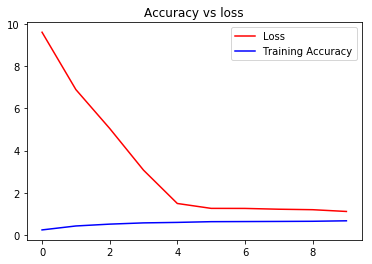

In [11]:
# Print a plot of loss and accuracy over epochs
#val_acc = history.history['val_acc']
train_acc = history.history['acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(len(history.history['acc']))

plt.title('Accuracy vs loss')
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, train_acc, 'blue', label='Training Accuracy')
plt.legend()

# plt.figure()
# plt.title('Training and validation loss')
# plt.plot(epochs, loss, 'red', label='Training loss')
# plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()



In [12]:
#model = load_model('test_model.h5')

# Evaluate the model on the validation data
loss, acc = model.evaluate_generator(TEST_GENERATOR, 272/32)
print("Loss: ", loss, " Accuracy: ", acc)

preds = model.predict_generator(TEST_GENERATOR, 272/32)
preds

Loss:  1.1501798682353075  Accuracy:  0.8602941176470589


array([[8.95023341e-25, 4.46064183e-30, 1.14780764e-26, ...,
        9.44729359e-21, 1.74164740e-32, 1.47712371e-26],
       [4.14239781e-10, 7.84118326e-10, 5.93793938e-12, ...,
        2.23049647e-13, 4.33866835e-15, 1.00000000e+00],
       [1.48884591e-14, 2.03170098e-12, 1.33049572e-14, ...,
        1.00000000e+00, 2.70566880e-09, 1.47392708e-18],
       ...,
       [2.71021850e-06, 9.31966743e-12, 8.61173501e-17, ...,
        1.98821516e-16, 1.42611160e-14, 9.99997258e-01],
       [0.00000000e+00, 1.68136125e-15, 1.91887821e-08, ...,
        7.47330622e-22, 1.06523594e-26, 7.08768475e-30],
       [4.35802760e-03, 1.19205266e-02, 3.66242148e-06, ...,
        3.36098462e-01, 4.89088207e-01, 9.90075222e-09]], dtype=float32)